In [2]:
import datetime
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from data import example_to_tensor, normalize
from train import EarlyStopping
from utils import plot_slice, plot_animated_volume

print(f"Tensorflow: {tf.__version__}")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Tensorflow: 2.3.0


In [3]:
verbose_training = True
# Hyperparameters
epochs = 1000
learning_rate = 0.0005
patience = 20
batch_size = 2
test_size = 2 # number of images
validation_size = 2  # number of batches
input_shape = (248, 128, 128, 1)  # downscale 4
# input_shape = (488, 256, 256, 1)  # downscale 2
# input_shape = (964, 512, 512, 1)  # original

In [4]:
data_dir = Path("data")
tfrecord_fnames = [
    str(p)
    for g in (data_dir.glob("tcia-0.25/*.tfrecord"), data_dir.glob("nrrd-0.25/*.tfrecord"))
    for p in g
]

full_dataset = tf.data.TFRecordDataset(tfrecord_fnames)
full_dataset = full_dataset.map(example_to_tensor)
full_dataset = full_dataset.map(normalize)
full_dataset = full_dataset.map(
   lambda x: tf.expand_dims(x, axis=-1)
)  # add the channel dimension

In [5]:
dataset = full_dataset
test_dataset = dataset.take(test_size)
test_dataset = test_dataset.batch(1)
dataset = dataset.skip(test_size)
dataset = dataset.padded_batch(batch_size=batch_size, padded_shapes=input_shape,)
val_dataset = dataset.take(validation_size)
train_dataset = dataset.skip(validation_size)
train_dataset = train_dataset.shuffle(buffer_size=64, reshuffle_each_iteration=True)
train_dataset = train_dataset.take(10)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
train_dataset

<PrefetchDataset shapes: (None, 248, 128, 128, 1), types: tf.float32>

In [38]:
def conv_block(filters, kernel_size=3, dropout_rate=0.1, pool_size=2):
    """
    - Convolution 3D
    - Selu activation
    - Dropout
    - Max pool 3D
    """
    return (
        keras.layers.Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(dropout_rate),
        keras.layers.MaxPool3D(pool_size=pool_size),
    )

In [39]:
def deconv_block(filters, kernel_size=3, dropout_rate=0.1, pool_size=2):
    """
    - Up sampling 3D
    - Convolution 3D
    - Selu activation
    - Dropout
    """
    return (
        keras.layers.UpSampling3D(size=pool_size),
        keras.layers.Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(dropout_rate),
    )

In [40]:
encoder = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape),
        *conv_block(filters=16),
        *conv_block(filters=32),
        *conv_block(filters=64),
    ]
)
encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 248, 128, 128, 16) 2016      
_________________________________________________________________
activation_7 (Activation)    (None, 248, 128, 128, 16) 0         
_________________________________________________________________
alpha_dropout_6 (AlphaDropou (None, 248, 128, 128, 16) 0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 124, 64, 64, 16)   0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 124, 64, 64, 32)   64032     
_________________________________________________________________
activation_8 (Activation)    (None, 124, 64, 64, 32)   0         
_________________________________________________________________
alpha_dropout_7 (AlphaDropou (None, 124, 64, 64, 32)  

In [41]:
decoder = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=encoder.layers[-1].output.shape[1:],),
        *deconv_block(64),
        *deconv_block(32),
        *deconv_block(16),
        keras.layers.Dense(1),
        keras.layers.Activation("sigmoid"),
    ]
)
decoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d_3 (UpSampling3 (None, 62, 32, 32, 64)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 62, 32, 32, 64)    512064    
_________________________________________________________________
activation_10 (Activation)   (None, 62, 32, 32, 64)    0         
_________________________________________________________________
alpha_dropout_9 (AlphaDropou (None, 62, 32, 32, 64)    0         
_________________________________________________________________
up_sampling3d_4 (UpSampling3 (None, 124, 64, 64, 64)   0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 124, 64, 64, 32)   256032    
_________________________________________________________________
activation_11 (Activation)   (None, 124, 64, 64, 32)  

In [42]:
autoencoder = keras.models.Sequential([encoder, decoder])
# autoencoder.load_weights("models/autoencoder/20200924-235155/best_epoch_ckpt")
# autoencoder = keras.models.load_model("models/autoencoder/20200924-235155")

#strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
#with strategy.scope():
#    autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.build((None, *input_shape))
autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 31, 16, 16, 64)    322112    
_________________________________________________________________
sequential_4 (Sequential)    (None, 248, 128, 128, 1)  832129    
Total params: 1,154,241
Trainable params: 1,154,241
Non-trainable params: 0
_________________________________________________________________


In [43]:
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(lr=learning_rate)

In [44]:
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
log_dir = f"logs/autoencoder/{start_time_str}/"
model_dir = f"models/autoencoder/{start_time_str}/"
ckpt_dir = model_dir + "best_epoch_ckpt"
writer = tf.summary.create_file_writer(log_dir)

early_stopping = EarlyStopping(patience)

for epoch in tqdm(range(epochs), disable=False):

    ### TRAIN ###

    train_loss_metric = tf.keras.metrics.Mean("train_loss", dtype=tf.float32)
    for batch in train_dataset:
        with tf.GradientTape() as tape:
            predictions = autoencoder(batch)
            loss_value = loss_fn(predictions, batch)
        gradients = tape.gradient(loss_value, autoencoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
        train_loss_metric.update_state(loss_value)
        with writer.as_default():
            for grad, param in zip(gradients, autoencoder.trainable_variables):
                tf.summary.histogram(param.name, param, step=epoch)
                # tf.summary.histogram(param.name + "/grad", grad, buckets=1, step=epoch)

    train_loss_mean = train_loss_metric.result()
    with writer.as_default():
        tf.summary.scalar("Training loss", train_loss_mean, step=epoch)
    train_loss_metric.reset_states()

    ### VALIDATION ###

    val_loss_metric = tf.keras.metrics.Mean("val_loss", dtype=tf.float32)
    for batch in val_dataset:
        predictions = autoencoder(batch)
        val_loss_metric.update_state(loss_fn(predictions, batch))

    val_loss_mean = val_loss_metric.result()
    with writer.as_default():
        tf.summary.scalar("Validation loss", val_loss_mean, step=epoch)
    val_loss_metric.reset_states()

    if verbose_training:
        print()
        print(f"Epoch : {epoch}")
        print(f"Training loss: {train_loss_mean}")
        print(f"Validation loss: {val_loss_mean}")

    ### EARLY STOPPING ###

    early_stopping.update(val_loss_mean)
    if early_stopping.early_stop:
        autoencoder.load_weights(ckpt_dir)
        break
    elif early_stopping.not_improving_epochs == 0:
        autoencoder.save_weights(ckpt_dir)

autoencoder.save(model_dir)

end_time = datetime.datetime.now()
training_time = str(end_time - start_time).split(".")[0]

with writer.as_default():
    tf.summary.text(
        "Hyperparameters",
        f"batch size = {batch_size}; "
        f"patience = {patience}; "
        f"learning rate = {learning_rate}; "
        f"training time = {training_time}",
        step=0,
    )


Epoch : 0
Training loss: 0.023537224158644676
Validation loss: 0.013111840933561325

Epoch : 1
Training loss: 0.020322047173976898
Validation loss: 0.013111840933561325

Epoch : 2
Training loss: 0.01582060381770134
Validation loss: 0.013111840933561325

Epoch : 3
Training loss: 0.01642705500125885
Validation loss: 0.013111840933561325

Epoch : 4
Training loss: 0.028345823287963867
Validation loss: 0.013111840933561325

Epoch : 5
Training loss: 0.021526992321014404
Validation loss: 0.013111840933561325

Epoch : 6
Training loss: 0.019941821694374084
Validation loss: 0.013111840933561325

Epoch : 7
Training loss: 0.023870175704360008
Validation loss: 0.013111840933561325

Epoch : 8
Training loss: 0.017921263352036476
Validation loss: 0.013111840933561325

Epoch : 9
Training loss: 0.02387092635035515
Validation loss: 0.013111840933561325

Epoch : 10
Training loss: 0.025602007284760475
Validation loss: 0.013111840933561325

Epoch : 11
Training loss: 0.02857966348528862
Validation loss: 0.0

In [1]:
%reload_ext tensorboard
%tensorboard --logdir=logs --bind_all

Reusing TensorBoard on port 6006 (pid 142900), started 7 days, 3:54:25 ago. (Use '!kill 142900' to kill it.)

In [46]:
original = next(iter(test_dataset))
encoder_out = autoencoder.layers[0](original)
decoder_out = autoencoder.layers[1](encoder_out)
batch_index = 0

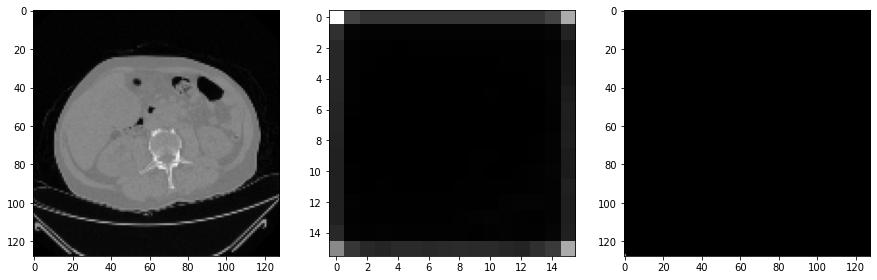

In [47]:
z_index = 20
fig, ax = plt.subplots(ncols=3)
plot_slice(original, batch_index, z_index, ax[0])
plot_slice(encoder_out, batch_index, encoder_out.shape[1] // 3, ax[1])
plot_slice(decoder_out, batch_index, z_index, ax[2])

In [ ]:
plot_animated_volume(original, batch_index)

In [ ]:
plot_animated_volume(encoder_out, batch_index, fps=10)

In [ ]:
plot_animated_volume(decoder_out, batch_index)